In [1]:
import numpy as np
import torch
from pinn_setup_fixed import PINN  # Make sure this is the cleaned-up file

# Define known solutions
def v1_true(x, y, t):
    return np.sin(np.pi * x) * np.cos(np.pi * y) * np.exp(-t)

def v5_true(x, y, t):
    return np.cos(np.pi * x) * np.sin(np.pi * y) * np.exp(-t)

# Generate synthetic training data
N = 1000
x = np.random.rand(N, 1)
y = np.random.rand(N, 1)
t = np.random.rand(N, 1)
v1 = v1_true(x, y, t)
v5 = v5_true(x, y, t)

# Define network
layers = [3, 64, 64, 64, 1]
model = PINN(x, y, t, v1, v5, layers=layers, use_pde=False)
model.setup_optimizers()
model.apply(model.xavier_init)

# Define loss
loss_fn = torch.nn.MSELoss()

# Train
for epoch in range(1000):
    loss = model.train_step(loss_fn, model.optimizer_v1, model.optimizer_v5)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss}")

Epoch 0: {'v1': 0.09008247405290604, 'v5': 0.25606706738471985, 'total': 0.3461495339870453}
Epoch 100: {'v1': 0.017189444974064827, 'v5': 0.012125745415687561, 'total': 0.029315190389752388}
Epoch 200: {'v1': 0.0013451935956254601, 'v5': 0.0023591972421854734, 'total': 0.0037043909542262554}
Epoch 300: {'v1': 0.0007126917480491102, 'v5': 0.001136527513153851, 'total': 0.0018492192029953003}
Epoch 400: {'v1': 0.000452454318292439, 'v5': 0.0006922140019014478, 'total': 0.0011446683201938868}
Epoch 500: {'v1': 0.00032735036802478135, 'v5': 0.0005296405288390815, 'total': 0.0008569909259676933}
Epoch 600: {'v1': 0.00021896962425671518, 'v5': 0.0003417744010221213, 'total': 0.0005607440252788365}
Epoch 700: {'v1': 0.00019422921468503773, 'v5': 0.0002599743602331728, 'total': 0.0004542035749182105}
Epoch 800: {'v1': 0.00014903899864293635, 'v5': 0.00023405413958244026, 'total': 0.0003830931382253766}
Epoch 900: {'v1': 0.0001151880351244472, 'v5': 0.00019885538495145738, 'total': 0.000314043

In [2]:
# Generate test data on a grid
x_test, y_test, t_test = np.meshgrid(
    np.linspace(0, 1, 20),
    np.linspace(0, 1, 20),
    np.linspace(0, 1, 5)
)
x_test = x_test.flatten()[:, None]
y_test = y_test.flatten()[:, None]
t_test = t_test.flatten()[:, None]

# Make predictions
preds = model.predict(x_test, y_test, t_test)
v1_pred = preds['v1']
v5_pred = preds['v5']

# Compute true values
v1_true_vals = v1_true(x_test, y_test, t_test)
v5_true_vals = v5_true(x_test, y_test, t_test)

# Evaluate Mean Squared Error
mse_v1 = np.mean((v1_pred - v1_true_vals)**2)
mse_v5 = np.mean((v5_pred - v5_true_vals)**2)

print(f"Test MSE for v1: {mse_v1:.3e}")
print(f"Test MSE for v5: {mse_v5:.3e}")

Test MSE for v1: 2.799e-04
Test MSE for v5: 3.512e-04


In [3]:
print(np.finfo(float).eps)

2.220446049250313e-16


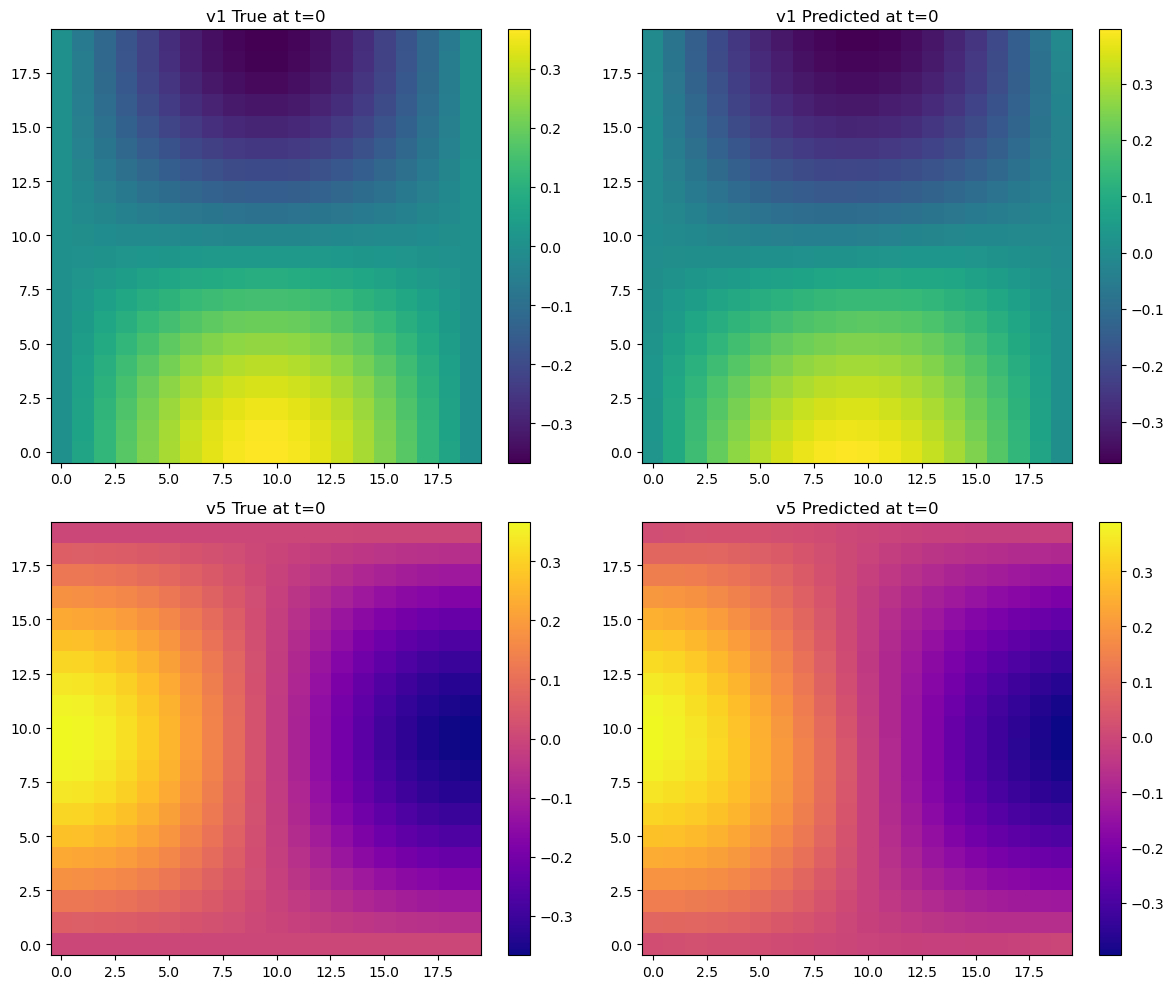

In [10]:
import matplotlib.pyplot as plt

# Filter t = 0 slice (assumes t_test was from np.meshgrid)
mask = np.abs(t_test[:, 0] - 1.0) < 1e-6
x_slice = x_test[mask][:, 0]
y_slice = y_test[mask][:, 0]

# Determine grid shape
nx = len(np.unique(x_slice))
ny = len(np.unique(y_slice))

# Reshape for imshow
def reshape_field(field_1d):
    return field_1d.reshape(ny, nx)

v1_true_grid = reshape_field(v1_true_vals[mask][:, 0])
v1_pred_grid = reshape_field(preds['v1'][mask][:, 0])
v5_true_grid = reshape_field(v5_true_vals[mask][:, 0])
v5_pred_grid = reshape_field(preds['v5'][mask][:, 0])

# Plot heatmaps
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

im0 = axs[0, 0].imshow(v1_true_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 0].set_title("v1 True at t=0")
plt.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(v1_pred_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 1].set_title("v1 Predicted at t=0")
plt.colorbar(im1, ax=axs[0, 1])

im2 = axs[1, 0].imshow(v5_true_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 0].set_title("v5 True at t=0")
plt.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(v5_pred_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 1].set_title("v5 Predicted at t=0")
plt.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [12]:
# TRUE physics data

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pinn_setup_fixed import PINN
from config.settings import LAYERS
from utils.data_loader import PlasmaDataLoader

# === 1. Load real physics dataset ===
data_loader = PlasmaDataLoader("data/plasma_data.h5")
data = data_loader.load_data()

x = data['x_train'].reshape(-1, 1)
y = data['y_train'].reshape(-1, 1)
t = data['t_train'].reshape(-1, 1)
v1 = data['v1_train'].reshape(-1, 1)
v5 = data['v5_train'].reshape(-1, 1)

# === 2. Create and initialize PINN ===
model = PINN(x, y, t, v1, v5, layers=LAYERS, use_pde=False)
model.setup_optimizers()
model.apply(model.xavier_init)

# === 3. Train the model ===
loss_fn = torch.nn.MSELoss()
for epoch in range(2000):
    loss = model.train_step(loss_fn, model.optimizer_v1, model.optimizer_v5)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: {loss}")

# === 4. Predict on a grid at t = 0 ===
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = np.linspace(y.min(), y.max(), 100)
t_fixed = 0.0

xg, yg = np.meshgrid(x_vals, y_vals)
tg = np.full_like(xg, t_fixed)

x_test = xg.reshape(-1, 1)
y_test = yg.reshape(-1, 1)
t_test = tg.reshape(-1, 1)

preds = model.predict(x_test, y_test, t_test)
v1_pred = preds['v1']
v5_pred = preds['v5']

# === 5. Extract true fields at t = 0 from training data (assumes dense coverage) ===
t_fixed = 0.0016  # or whatever shows up in unique_times
tol = 1e-6
mask = np.abs(t[:, 0] - t_fixed) < tol
print("Matched points:", np.sum(mask))

v1_true_grid = v1[mask].reshape(100, 100)
v5_true_grid = v5[mask].reshape(100, 100)
v1_pred_grid = v1_pred.reshape(100, 100)
v5_pred_grid = v5_pred.reshape(100, 100)

# === 6. Plot predicted vs. true fields ===
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

im0 = axs[0, 0].imshow(v1_true_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 0].set_title("v1 True at t=0")
plt.colorbar(im0, ax=axs[0, 0])

im1 = axs[0, 1].imshow(v1_pred_grid, origin='lower', cmap='viridis', aspect='auto')
axs[0, 1].set_title("v1 Predicted at t=0")
plt.colorbar(im1, ax=axs[0, 1])

im2 = axs[1, 0].imshow(v5_true_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 0].set_title("v5 True at t=0")
plt.colorbar(im2, ax=axs[1, 0])

im3 = axs[1, 1].imshow(v5_pred_grid, origin='lower', cmap='plasma', aspect='auto')
axs[1, 1].set_title("v5 Predicted at t=0")
plt.colorbar(im3, ax=axs[1, 1])

plt.tight_layout()
plt.show()

Epoch 0: {'v1': 0.09757183492183685, 'v5': 2.0564022064208984, 'total': 2.1539740562438965}
Epoch 100: {'v1': 0.003819420700892806, 'v5': 0.114637091755867, 'total': 0.11845651268959045}
Epoch 200: {'v1': 0.0035535134375095367, 'v5': 0.11116837710142136, 'total': 0.11472189426422119}
Epoch 300: {'v1': 0.003498814767226577, 'v5': 0.10441853106021881, 'total': 0.10791734606027603}
Epoch 400: {'v1': 0.0027234512381255627, 'v5': 0.09984385222196579, 'total': 0.10256730020046234}
Epoch 500: {'v1': 0.002725436585023999, 'v5': 0.08675730973482132, 'total': 0.08948274701833725}
Epoch 600: {'v1': 0.002890143310651183, 'v5': 0.08961094915866852, 'total': 0.09250108897686005}
Epoch 700: {'v1': 0.0030784173868596554, 'v5': 0.09219301491975784, 'total': 0.09527143090963364}
Epoch 800: {'v1': 0.002381674014031887, 'v5': 0.07242860645055771, 'total': 0.07481028139591217}
Epoch 900: {'v1': 0.0025074954610317945, 'v5': 0.07124317437410355, 'total': 0.07375066727399826}
Epoch 1000: {'v1': 0.002341949148

ValueError: cannot reshape array of size 0 into shape (100,100)